<a href="https://colab.research.google.com/github/sanjayathreya/cs598dl4h-project/blob/main/src/Descriptive-Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Reproducibility summary**

This notebook describes the methods followed by the paper **Chang Lu, Tian Han, and Yue Ning. 2021a. Context- aware health event prediction via transition functions on dynamic disease graphs(Chet). ArXiv, abs/2112.05195**

1.   **Claim 1**: For heart failure prediction task, Chet outperforms the baseline models based on metrics such as **AUC and F1-scores on MIMIC III and MIMIC IV data sets.**

2. **Claim 2**: For diagnosis prediction task, Chet outperforms the baseline models based on MIMIC III and MIMIC IV data sets. The authors compare w-F1 is a weighted sum of F1 scores for all medical codes and R@k which is an average ratio of desired medical codes in top k predictions by the total number of desired medical codes in each visit.

To verify these claims, we reproduced these results MIMIC III- carevue (Johnson et al., 2022) which excludes overlap of patients in MIMIC IV, and MIMIC IV (Johnson et al., 2023). Additionally, we investigated the effectiveness of the model under different experimental setups such comparing performance of model by changing the number of training epochs, using a different pre-processing
method to extract data, ablation studies that do not include dynamic graph and transition functions.

***This notebook describes the methods followed on reproducing the paper on [MIMIC III carevue dataset](https://physionet.org/content/mimic3-carevue/1.4/)***








# Initial setup

In [ ]:
!git clone https://github.com/sanjayathreya/cs598dl4h-project
!mv /content/cs598dl4h-project /content/CHET

Cloning into 'cs598dl4h-project'...
remote: Enumerating objects: 354, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 354 (delta 21), reused 9 (delta 5), pack-reused 321
Receiving objects: 100% (354/354), 14.74 MiB | 17.09 MiB/s, done.
Resolving deltas: 100% (201/201), done.


Please copy the files 
* paitients.csv
* admissions.csv
* diagnoses_icd.csv 

to
* mimic3 folder /content/CHET/data/mimic3/raw/
* mimic4 folder /content/CHET/data/mimic4/raw/

In [ ]:
#@title This copy command needs to be updated to reproduce
from google.colab import drive
drive.mount('/content/drive')
!cp -a /content/drive/MyDrive/CHET/data/mimic3/raw/ /content/CHET/data/mimic3/
!cp -a /content/drive/MyDrive/CHET/data/mimic4/raw/ /content/CHET/data/mimic4/

In [ ]:
%cd /content/CHET/

/content/CHET


In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.8/113.8 kB 134.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 57.7 MB/s eta 0:00:00


Change working directory to CHET/src

In [ ]:
%cd /content/CHET/src
%pwd

/content/CHET/src


'/content/CHET/src'

# Preprocessing and dataset statistics

In order to preprocess MIMIC4dataset we need to copy over the mapping of ICD10CM to ICD9CM to the cache folder on the containerized colab environment.

In [ ]:
from pyhealth.medcode import CrossMap
from pyhealth.datasets import MIMIC4Dataset,MIMIC3Dataset
!cp /content/CHET/ICD10CM_to_ICD9CM.csv /root/.cache/pyhealth/medcode

At first, lets glance through the statistics of the dataset in parsed folder directly.


In [ ]:
from preprocess import *
import os
import pandas as pd

data_path = os.path.join('..','data')
datasets = ['mimic3','mimic4']
res =[]
for dataset_ in datasets:
  parsed_main_path = os.path.join(data_path, dataset_, 'parsed')
  patient_admission = pickle.load(open(os.path.join(parsed_main_path, 'patient_admission.pkl'), 'rb'))
  admission_codes = pickle.load(open(os.path.join(parsed_main_path, 'admission_codes.pkl'), 'rb'))
  df_ = get_stats_df(patient_admission, admission_codes)
  df_['dataset'] = dataset_
  res.append(df_)

res = pd.concat(res)
res

,# patients,# maximum visits,average # visits,max # diagnoses codes,avg # diagnoses codes,dataset
0,2169,23,2.447211,39,10.703090,mimic3
0,10000,93,3.794900,39,13.513479,mimic4


Now, let us review the steps in parsing process for MIMIC III Carevue subset

In [ ]:
dataset = 'mimic3'
data_path = os.path.join('..','testing')
dataset_path = os.path.join(data_path,dataset)
parsed_main_path = os.path.join(dataset_path, 'parsed')
# initial setting to ex
patient_admission, admission_codes = generate_parsed_datesets(dataset,parsed_main_path,ret_value=True)
df = get_stats_df(patient_admission, admission_codes)
df

operating on path /content/CHET/src


Loaded datasets in pyhealth



Creating Parsed datasets for each paitient: 100%|██████████| 23692/23692 [00:00<00:00, 168406.49it/s]


saving parsed data

saved patient_admission data ...
saved admission_codes data ...


,# patients,# maximum visits,average # visits,max # diagnoses codes,avg # diagnoses codes
0,2169,23,2.447211,39,10.702148


# Preprocessing Tasks

**Step 1**: Use Tokenizer object in pyhealth to encode admission codes

In [ ]:
seed =2
dataset_path = os.path.join(data_path,dataset)
encoded_path = os.path.join(dataset_path, 'encoded')
standard_path = os.path.join(dataset_path, 'standard')
max_admission_num = get_stats(patient_admission, admission_codes)

patient_admission, admission_codes = generate_parsed_datesets(dataset,parsed_main_path,ret_value=True)

# Generate code map and encode admission_codes
codes = list(admission_codes.values())
codes = list(set(flatten_list(codes)))
tokenizer = Tokenizer(tokens=codes)
code_map = tokenizer.vocabulary.token2idx
admission_codes_encoded = { admission_id: list(set(tokenizer.convert_tokens_to_indices(codes))) for admission_id, codes in admission_codes.items() }
code_num = len(code_map)
print('There are %d codes' % code_num)

patient num: 2169
max admission num: 23
mean admission num: 2.45
max code num in an admission: 39
mean code num in an admission: 10.70
operating on path /content/CHET/src


Loaded datasets in pyhealth



Creating Parsed datasets for each paitient: 100%|██████████| 23692/23692 [00:00<00:00, 195090.80it/s]


saving parsed data

saved patient_admission data ...
saved admission_codes data ...


There are 2821 codes


**Step 2**: Generate code levels. In this step we take the diagnoses codes for all admissions encode them into a 3 level hierarchy. This hiearchy is derived using ancestoral relationship in pyhealth. Where there are more than 3 levels , we force the hierarchy to three levels. The approach is similar to the one followed by the authors of the paper.

In [ ]:
# diagnosis code levels

code_levels = generate_code_levels(code_map)
print("\ncompleted code levels")
code_levels[:2]

generating code level matrix for codes: 100%|██████████| 2821/2821 [00:00<00:00, 19977.39it/s]


completed code levels


array([[  8,  75, 384,   0],
       [ 16, 125, 603,   1]])

**Step3**: Split patients into Train , validation and test datasets. 

While performing the split , we ensure that all diagnoses codes are seen in the training set and the admission with maximum number of diagnosis codes are also included. The reason is to ensure no unseen codes in testing and ensure no out of memory exceptions during testing.

After this step we save all encoded datasets to encoded folder for further processing.

In [ ]:
# Split dataset to train , validation, test 80/10/10
train_pids, valid_pids, test_pids  = split_patients(patient_admission, admission_codes, code_map, ratios=(.80,.10,.10), seed=seed)
all_pids = { 'train_pids': train_pids, 'valid_pids': valid_pids, 'test_pids': test_pids }
save_files(encoded_path, patient_admission =patient_admission, codes_encoded=admission_codes_encoded, code_map = code_map, pids = all_pids)

Split Paitents: 100%|██████████| 2821/2821 [00:00<00:00, 721735.49it/s]

Split patient_admission #: 2169 into 
	 Train #: 1735 
	 Validation #: 218 
	 Test #: 216
saved patient_admission data ...
saved codes_encoded data ...
saved code_map data ...
saved pids data ...


**Step5**: In this step, we generate the code code adjacency matrix   

If a diagnosis code pair $(c_i, c_j)$, co-occurred in ***a*** patients visit then , two edges with $\overrightarrow{(i,j)}$ and $\overleftarrow{(i,j)}$  are recorded. These are asymmetric because the authors surmise that two diseases may not have equal influence on each other. $f_{ij}$ is the total co-occurrence frequency $(c_i, c_j)$ for **all** patient visits. In order to detect important disease relationships, they filter out combinations with low frequency. $\Delta_i = {c_j | 
\frac{f_{ij}}{\sum_{j=1}^{d}f_{ij}} \geq \delta}$. This is stored in adjacency matrix $\mathcal{A}$ which is static and measures global co-occurrence frequencies of diseases.

In [ ]:
# generate global adjacency matrix
adj_matrix = generate_code_code_adjacent(train_pids, patient_admission, admission_codes_encoded, code_num, threshold=0.01)
norm_adj_matrix = normalize_adj(adj_matrix)
save_dict = {'code_adj': norm_adj_matrix}
save_files(standard_path, type='standard', **save_dict)

generating global code code adjacent matrix: 100%|██████████| 1735/1735 [00:00<00:00, 4913.25it/s]


**Step6**: In this step, there are 4 parts 

**Part 1** We build the X, Y and visit_lens matrices. 


*   For each patient X consists of paitient ids, admission codes encoded, and 
diagnosis codes X[pid, admission_number, encoded_diagnoses_id] except for the last visit.

*   Y is a true label matrix of admission_number and last diagnosis code we would like to use for prediction. [admission_number, encoded_diagnoses_id]

*  visit_lens is a number of admissions excluding last visit [len admissions -1]

**Part 2** Build a code of neighbors $\mathcal{N_{ij}^t}$

$\mathcal{N_{ij}^t} = \mathcal{A_{ij}}$ if $(c_i, c_j)$ are two neighbors and are not diagnosed in visit t. Otherwise = 0

**Part 3** Build matrices to store local diagnosis graph and global diagnosis-neigbor graphs which are bipartite, shown below digrammatically.

**Part 4** Build Y matrix for heart failure prediction. The label for HF is 1 when diagnosis code is *428*

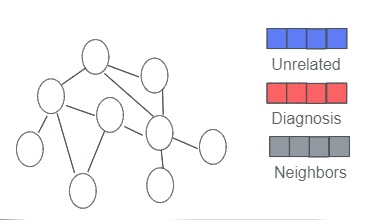



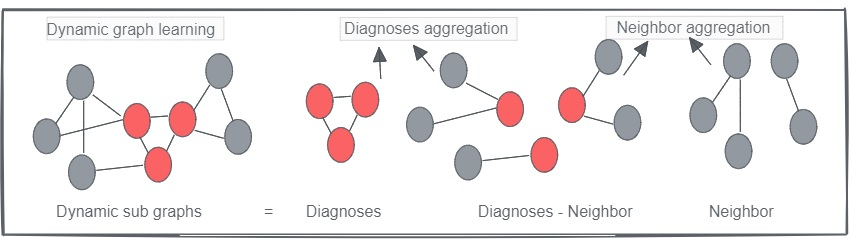



In [ ]:
# generate all datasets
datasets = ['train', 'valid', 'test' ]
for idx, dataset in enumerate(datasets):
  if dataset == 'train':
    pids = train_pids
  elif dataset == 'valid':
    pids = valid_pids
  else:
    pids = test_pids
  print(f'\nprocessing standard data for {dataset}\n')
  (X, Y, visit_lens) = construct_x_y(pids, patient_admission, admission_codes_encoded, max_admission_num, code_num)
  N_t = build_neighbor_codes(X, visit_lens, adj_matrix)
  M_t = divide_disease_type_matrices(X, N_t, visit_lens)
  Y_hf = construct_hf_label_y(Y, code_map)

  std_path = os.path.join(standard_path, dataset)
  save_dict = {'code_x': X, 'visit_lens': visit_lens , 'code_y': Y,
              'hf_y': Y_hf, 'divided': M_t, 'neighbors': N_t}

  print(f'\nsaving standard data for {dataset}\n')
  save_files(std_path, type='standard', **save_dict )


processing standard data for train



generating neighbors matrix: 100%|██████████| 1735/1735 [00:00<00:00, 4855.02it/s]
generating divided matrices local, bipertite diagnoses-neighbor m_p,m_en,m_eu: 100%|██████████| 1735/1735 [00:00<00:00, 30981.35it/s]



saving standard data for train


processing standard data for valid



generating neighbors matrix: 100%|██████████| 218/218 [00:00<00:00, 5169.87it/s]
generating divided matrices local, bipertite diagnoses-neighbor m_p,m_en,m_eu: 100%|██████████| 218/218 [00:00<00:00, 30839.43it/s]


saving standard data for valid




processing standard data for test



generating neighbors matrix: 100%|██████████| 216/216 [00:00<00:00, 5150.66it/s]
generating divided matrices local, bipertite diagnoses-neighbor m_p,m_en,m_eu: 100%|██████████| 216/216 [00:00<00:00, 26905.73it/s]


saving standard data for test



# Model Construction

## Layers

### Embedding layer



1.   Two embedding matrices $\mathbf{M,N}$ of size $s$ are used to embed diseases and their neighbours. They are shown in the code below as c_embeddings and n_embeddings
2.   Unrelated diseases are embedded in matrix $\mathbf{R}$ of size of size $s^{\prime}$. They are shown below in code as u_embeddings

 


In [ ]:
import torch
from torch import nn
class EmbeddingLayer(nn.Module):
    def __init__(self, code_num, code_size, graph_size):
        super().__init__()
        self.code_num = code_num
        self.c_embeddings = nn.Parameter(data=nn.init.xavier_uniform_(torch.empty(code_num, code_size)))
        self.n_embeddings = nn.Parameter(data=nn.init.xavier_uniform_(torch.empty(code_num, code_size)))
        self.u_embeddings = nn.Parameter(data=nn.init.xavier_uniform_(torch.empty(code_num, graph_size)))

    def forward(self):
        return self.c_embeddings, self.n_embeddings, self.u_embeddings

### Graph layer
A graph neural network GNN is used to learn diagnosis and its neighbours that may influence future visits. The graph layer is summarized as 

$$
\mathbf{Z}^t_D = \mathbf{m}^t \odot \mathbf{M} + \underbrace{\mathcal{M}_t\mathbf{M}}_{\text{local context}} +\underbrace{ \mathcal{B}_t\mathbf{N}}_{\text{diagnosis global context}}
$$
$$\mathbf{Z}^t_N = \mathbf{n}^t \odot \mathbf{N} + \underbrace{\mathcal{N}_t\mathbf{N} + \mathcal{\hat{B}}_t\mathbf{M}}_{\text{neighbor global context}}
$$

The authors prove that these multiplications can be simplified further,

$$\mathcal{B}_t\mathbf{N} = \mathcal{m_t} \odot (\mathcal{A} (\mathcal{n_t} \odot \mathbf{N}))$$

$$\mathcal{M}_t\mathbf{N} = \mathcal{m_t} \odot (\mathcal{A} (\mathcal{m_t} \odot \mathbf{N}))$$

$$\mathcal{N}_t\mathbf{N} = \mathcal{n_t} \odot (\mathcal{A} (\mathcal{n_t} \odot \mathbf{N}))$$

$$\mathcal{\hat{B}}_t\mathbf{M} = \mathcal{n_t} \odot (\mathcal{A} (\mathcal{n_t} \odot \mathbf{M}))$$

$\odot$ signifies elementwise multiplication. The hidden embeddings of diagnoses and neighbors, i.e., GNN outputs, are calculated with a fully connected layer , $\mathbf{W}$ is the weight matrix.
$$
\mathbf{H}^t_{{D,N}} = \text{LeakyReLU} (\mathbf{Z}^t_{{D,N}} \mathbf{W})
$$

In [ ]:
class GraphLayer(nn.Module):
    def __init__(self, adj, code_size, graph_size):
        super().__init__()
        self.adj = adj
        self.dense = nn.Linear(code_size, graph_size)
        self.activation = nn.LeakyReLU()

    def forward(self, code_x, neighbor, c_embeddings, n_embeddings):
        center_codes = torch.unsqueeze(code_x, dim=-1)
        neighbor_codes = torch.unsqueeze(neighbor, dim=-1)

        center_embeddings = center_codes * c_embeddings
        neighbor_embeddings = neighbor_codes * n_embeddings
        cc_embeddings = center_codes * torch.matmul(self.adj, center_embeddings)
        cn_embeddings = center_codes * torch.matmul(self.adj, neighbor_embeddings)
        nn_embeddings = neighbor_codes * torch.matmul(self.adj, neighbor_embeddings)
        nc_embeddings = neighbor_codes * torch.matmul(self.adj, center_embeddings)

        co_embeddings = self.activation(self.dense(center_embeddings + cc_embeddings + cn_embeddings))
        no_embeddings = self.activation(self.dense(neighbor_embeddings + nn_embeddings + nc_embeddings))
        return co_embeddings, no_embeddings

### Transition functions

For the diagnosis vector $m_t$ in visit t, when t $\geq$ 2, the authors divide $m_t$ into three disjoint parts 
1.    Persistent diseases $m^t_p$, those are noses in visit $t$ that are also diagnoses in previous visit $t$-1.
2.    Emerging diseases $m^t_{en}$, Diagnoses in visit $t$ that are neighbors in visit $t$-1.
3.   Emerging unrelated diseases} $m^t_{eu}$, Diagnoses in visit $t$ that are unrelated diseases in visit $t$-1.

To perform temporal learning on diagnoses, the paper proposed are 3 separate transition functions. It is pictorially represented below

The hidden states, 
1.   $h^t_{en}$  
2.   $h^t_{eu}$ are computed using scaled dot product attention ([Vaswani2017Attention](https://arxiv.org/abs/1706.03762))
and $a$ is the attention size. 

In the attention layer, 
*   For $h^t_{en}$ we use hidden neighbor embeddings $h^{t-1}_{N}$ query Q and key K. 
*   For $h^t_{eu}$ we use universal embeddings of unrelated diseases as Q and K.

For both  hidden diagnosis embeddings $H^t_D$ is used as value V in attention

3.    The transition function to model $h^t_{p}$ is computed by means of a Modified-GRU(M-GRU) which takes in hidden embeddings $H^t_D$ of diagnoses in visit $t$, transition outputs $h^t_{en}$ and $h^t_{eu}$ of emerging diseases in visit $t$, and the hidden state as well as the M-GRU output $h^{t-1}_{p}$. Besides making the original GRU work for matrices, the M-GRU  is modified in a way that it applies a $tanh$ activation function to hidden state of emerging diseases. Subsequently, they store the hidden state of emerging diseases to the hidden state of persistent diseases for the next visit.



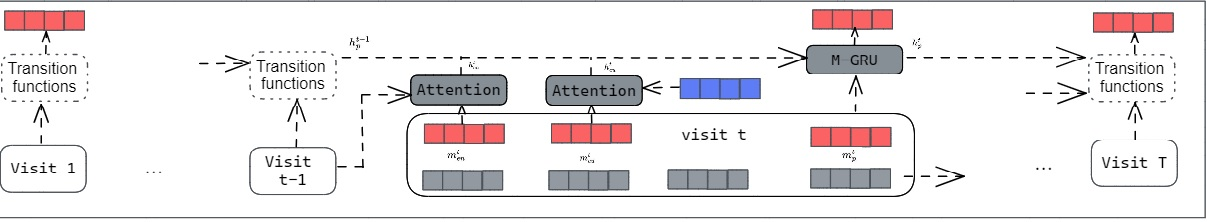

In [ ]:
from attention import SingleHeadAttentionLayer

class TransitionLayer(nn.Module):
    def __init__(self, code_num, graph_size, hidden_size, t_attention_size, t_output_size):
        super().__init__()
        self.gru = nn.GRUCell(input_size=graph_size, hidden_size=hidden_size)
        self.single_head_attention = SingleHeadAttentionLayer(graph_size, graph_size, t_output_size, t_attention_size)
        self.activation = nn.Tanh()

        self.code_num = code_num
        self.hidden_size = hidden_size

    def forward(self, t, co_embeddings, divided, no_embeddings, unrelated_embeddings, hidden_state=None):
        m1, m2, m3 = divided[:, 0], divided[:, 1], divided[:, 2]
        m1_index = torch.where(m1 > 0)[0]
        m2_index = torch.where(m2 > 0)[0]
        m3_index = torch.where(m3 > 0)[0]
        h_new = torch.zeros((self.code_num, self.hidden_size), dtype=co_embeddings.dtype).to(co_embeddings.device)
        output_m1 = 0
        output_m23 = 0
        if len(m1_index) > 0:
            m1_embedding = co_embeddings[m1_index]
            h = hidden_state[m1_index] if hidden_state is not None else None
            h_m1 = self.gru(m1_embedding, h)
            h_new[m1_index] = h_m1
            output_m1, _ = torch.max(h_m1, dim=-2)
        if t > 0 and len(m2_index) + len(m3_index) > 0:
            q = torch.vstack([no_embeddings[m2_index], unrelated_embeddings[m3_index]])
            v = torch.vstack([co_embeddings[m2_index], co_embeddings[m3_index]])
            h_m23 = self.activation(self.single_head_attention(q, q, v))
            h_new[m2_index] = h_m23[:len(m2_index)]
            h_new[m3_index] = h_m23[len(m2_index):]
            output_m23, _ = torch.max(h_m23, dim=-2)
        if len(m1_index) == 0:
            output = output_m23
        elif len(m2_index) + len(m3_index) == 0:
            output = output_m1
        else:
            output, _ = torch.max(torch.vstack([output_m1, output_m23]), dim=-2)
        return output, h_new

### Final Model

The authors use max pooling for the transition output of the three parts and calculate the visit embedding $v_t$. In the final step, to calculate patient embedding $o$ for all visits, they use location-based attention [Luong2015EffectiveAT](https://arxiv.org/abs/1508.04025). This is used in a classifier for final predictions of a specific task. 

The model uses a fully connected layer with a sigmoid activation function as the classifier and a binary cross entropy loss as the objective function.

In [ ]:
from attention import DotProductAttention

class Classifier(nn.Module):
    def __init__(self, input_size, output_size, dropout_rate=0., activation=None):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.activation = activation
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        output = self.dropout(x)
        output = self.linear(output)
        if self.activation is not None:
            output = self.activation(output)
        return output


class Model(nn.Module):
    def __init__(self, code_num, code_size,
                 adj, graph_size, hidden_size, t_attention_size, t_output_size,
                 output_size, dropout_rate, activation):
        super().__init__()
        print('Model')
        self.embedding_layer = EmbeddingLayer(code_num, code_size, graph_size)
        self.graph_layer = GraphLayer(adj, code_size, graph_size)
        self.transition_layer = TransitionLayer(code_num, graph_size, hidden_size, t_attention_size, t_output_size)
        self.attention = DotProductAttention(hidden_size, 32)
        self.classifier = Classifier(hidden_size, output_size, dropout_rate, activation)

    def forward(self, code_x, divided, neighbors, lens):
        embeddings = self.embedding_layer()
        c_embeddings, n_embeddings, u_embeddings = embeddings
        output = []
        for code_x_i, divided_i, neighbor_i, len_i in zip(code_x, divided, neighbors, lens):
            no_embeddings_i_prev = None
            output_i = []
            h_t = None
            for t, (c_it, d_it, n_it, len_it) in enumerate(zip(code_x_i, divided_i, neighbor_i, range(len_i))):
                co_embeddings, no_embeddings = self.graph_layer(c_it, n_it, c_embeddings, n_embeddings)
                output_it, h_t = self.transition_layer(t, co_embeddings, d_it, no_embeddings_i_prev, u_embeddings, h_t)
                no_embeddings_i_prev = no_embeddings
                output_i.append(output_it)
            output_i = self.attention(torch.vstack(output_i))
            output.append(output_i)
        output = torch.vstack(output)
        output = self.classifier(output)
        return output

# Training

## Parameters

*   In the base implementation, the hyper-parameters as well as activation functions are tuned on the validation set. 
*   The initial **learning rate** is set to 0.01. A multi-step LR scheduler methodology is used where the learning rate decays by [1e-3, 1e-5] at the milestones $[20, 30]$ respectively on diagnosis prediction. 
*   This is modified to [1e-3, 1e-4, 1e-5] at the milestones $[2, 3, 20]$ respectively for heart failure prediction. **Batch size is 32**. 
*   The remaining parameters are described below

| Parameter                           | MIMIC III | MIMIC IV |
|-------------------------------------|-----------|----------|
| Node frequency threshold $\delta$   | 0.01      | 0.01     |
| Embedding size $s$ for $M$, $N$     | 48        | 48       |
| Embedding size $s^{\prime}$ for $R$ | 32        | 32       |
| Attention size $a$                  | 32        | 32       |
| Hidden units diag pred.             | 256       | 350      |
| Hidden units HF pred.               | 100       | 150      |


In [ ]:
import random
import time
import numpy as np
from utils import load_adj, EHRDataset, format_time, MultiStepLRScheduler
from metrics import evaluate_codes, evaluate_hf
from config import config
from train import historical_hot

model = 'base-model'
datasets = ['mimic3'] # ['mimic3', 'mimic4']
task = 'h' # 'h'or 'm'
seeds = [2000]



use_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')
config, code_size, graph_size, t_attention_size, batch_size, epochs = config()
epochs = 11 # override epochs for this exercise

milestones = [2, 3, 10]  #override MRlearning milestones
lrs= [1e-3, 1e-4, 1e-5] #override MRlearning learning rates

res = []
for dataset in datasets:
  for idx, seed in enumerate(seeds):
      random.seed(seed)
      np.random.seed(seed)
      torch.manual_seed(seed)
      torch.cuda.manual_seed(seed)

      dataset_path = os.path.join('..','testing', dataset, 'standard')
      train_path = os.path.join(dataset_path, 'train')
      valid_path = os.path.join(dataset_path, 'valid')

      code_adj = load_adj(dataset_path, device=device)
      code_num = len(code_adj)
      print('loading train data ...')
      train_data = EHRDataset(train_path, label=task, batch_size=batch_size, shuffle=True, device=device)
      print('loading valid data ...')
      valid_data = EHRDataset(valid_path, label=task, batch_size=batch_size, shuffle=False, device=device)


      test_historical = historical_hot(valid_data.code_x, code_num, valid_data.visit_lens)

      if task == 'm':
          output_size = code_num
      else:
          output_size = 1

      activation = torch.nn.Sigmoid()
      loss_fn = torch.nn.BCELoss()
      evaluate_fn = config[task]['evaluate_fn']
      dropout_rate = config[task]['dropout']
      hidden_size = config[task]['hidden_size'][dataset]
      t_output_size = hidden_size

      if model == 'base-model':
          print('Calling Base Model')
          param_path = os.path.join('..','testing', 'params', dataset, task, str(idx))
          model = Model(code_num=code_num, code_size=code_size,
                        adj=code_adj, graph_size=graph_size, hidden_size=hidden_size,
                        t_attention_size=t_attention_size,
                        t_output_size=t_output_size,
                        output_size=output_size, dropout_rate=dropout_rate, activation=activation).to(device)

      if not os.path.exists(param_path):
          os.makedirs(param_path)

      optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
      scheduler = MultiStepLRScheduler(optimizer, epochs, config[task]['lr']['init_lr'],
                                        milestones, lrs)

      pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
      print(pytorch_total_params)

      train_start_time = time.time()
      for epoch in range(epochs):
          print('Epoch %d / %d:' % (epoch + 1, epochs))
          model.train()
          total_loss = 0.0
          total_num = 0
          steps = len(train_data)
          st = time.time()
          scheduler.step()
          for step in range(len(train_data)):
              optimizer.zero_grad()
              code_x, visit_lens, divided, y, neighbors = train_data[step]
              output = model(code_x, divided, neighbors, visit_lens).squeeze()
              loss = loss_fn(output, y)
              loss.backward()
              optimizer.step()
              total_loss += loss.item() * output_size * len(code_x)
              total_num += len(code_x)

              end_time = time.time()
              remaining_time = format_time((end_time - st) / (step + 1) * (steps - step - 1))
              print('\r    Step %d / %d, remaining time: %s, loss: %.4f'
                    % (step + 1, steps, remaining_time, total_loss / total_num), end='')
          train_data.on_epoch_end()
          et = time.time()
          time_cost = format_time(et - st)
          print('\r    Step %d / %d, time cost: %s, loss: %.4f' % (
          steps, steps, time_cost, total_loss / total_num))
          valid_loss, f1_score = evaluate_fn(model, valid_data, loss_fn, output_size, test_historical)
          torch.save(model.state_dict(), os.path.join(param_path, '%d.pt' % epoch))

      train_end_time = time.time()
      result = {
          'dataset_name': dataset,
          'sample': task,
          'seed#': seed,
          'seed_idx': idx,
          'total_params': pytorch_total_params,
          'train_time': (train_end_time - train_start_time)
      }
      df_ = pd.DataFrame(result, index=[0])
      res.append(df_)
      print(f'\n******Completed training dataset:{dataset} task:{task} seed:{seed} idx:{idx} time: {format_time(train_end_time - train_start_time)}******\n')

df = pd.concat(res)
# Write preprocessing time to output directory
output_dir = os.path.join('..','testing','out')
if not os.path.exists(output_dir):
  os.makedirs(output_dir)
output_file = os.path.join(output_dir,'output_training.csv')

df.to_csv(output_file, index=False)

loading train data ...
loading valid data ...
Calling Base Model
Model
411633
Epoch 1 / 11:
    Step 55 / 55, time cost: 8.3s, loss: 0.6083
    Evaluation: loss: 0.6584 --- auc: 0.7044 --- f1_score: 0.5684
Epoch 2 / 11:
    Step 55 / 55, time cost: 8.1s, loss: 0.4910
    Evaluation: loss: 0.6237 --- auc: 0.7153 --- f1_score: 0.5309
Epoch 3 / 11:
    Step 55 / 55, time cost: 8.0s, loss: 0.4636
    Evaluation: loss: 0.6246 --- auc: 0.7162 --- f1_score: 0.5309
Epoch 4 / 11:
    Step 55 / 55, time cost: 8.2s, loss: 0.4605
    Evaluation: loss: 0.6258 --- auc: 0.7163 --- f1_score: 0.5309
Epoch 5 / 11:
    Step 55 / 55, time cost: 8.1s, loss: 0.4571
    Evaluation: loss: 0.6271 --- auc: 0.7162 --- f1_score: 0.5309
Epoch 6 / 11:
    Step 55 / 55, time cost: 8.0s, loss: 0.4539
    Evaluation: loss: 0.6278 --- auc: 0.7162 --- f1_score: 0.5276
Epoch 7 / 11:
    Step 55 / 55, time cost: 8.1s, loss: 0.4508
    Evaluation: loss: 0.6298 --- auc: 0.7161 --- f1_score: 0.5366
Epoch 8 / 11:
    Step 55 

### Evaluation

In [ ]:
from eval import eval_hf, eval_diag, get_dataset_tensors
datasets = [ 'mimic3'] #['mimic3', 'mimic4']  
tasks = ['h'] # 'm' or 'h'
use_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')

# Model Parameters
code_size = 48
graph_size = 32
t_attention_size = 32
batch_size = 1
epochs = 200

task_conf = {
    'm': {
        'dropout': 0.45,
        'evaluate_fn': eval_diag,
        'hidden_size_mimic3': 256,
        'hidden_size_mimic4': 350,
    },
    'h': {
        'dropout': 0.0,
        'evaluate_fn': eval_hf,
        'hidden_size_mimic3': 100,
        'hidden_size_mimic4': 150,
    }
}
seeds = [2000]
restask_h =[]
restask_m = []
for task in tasks:
    for dataset in datasets:
        for idx, seed in enumerate(seeds):
            print('loading test data ...')
            dataset_path = os.path.join('..','testing', dataset, 'standard')
            test_path = os.path.join(dataset_path, 'test')
            train_path = os.path.join(dataset_path, 'train')
            valid_path = os.path.join(dataset_path, 'valid')
            print('loading code_adj ...')
            code_adj = load_adj(dataset_path, device=device)
            code_num = len(code_adj)
            print(f'code_adj size {code_num}')

            test_data = EHRDataset(test_path, label=task, batch_size=batch_size, shuffle=False, device=device)
            test_historical = historical_hot(test_data.code_x, code_num, test_data.visit_lens)
            train_data = EHRDataset(train_path, label=task, batch_size=batch_size, shuffle=False, device=device)
            valid_data = EHRDataset(valid_path, label=task, batch_size=batch_size, shuffle=False, device=device)

            print(f'train {np.count_nonzero(train_data.y == 1)}')
            print(f'test {np.count_nonzero(test_data.y == 1)}')
            print(f'valid {np.count_nonzero(valid_data.y == 1)}')

            if dataset == 'mimic3':
                hidden_size = task_conf[task]['hidden_size_mimic3']
            else:
                hidden_size = task_conf[task]['hidden_size_mimic4']

            activation = torch.nn.Sigmoid()
            evaluate_fn = task_conf[task]['evaluate_fn']
            dropout_rate = task_conf[task]['dropout']

            if task == 'm':
                output_size = code_num
            else:
                output_size = 1

            t_output_size = hidden_size
            model = Model(code_num=code_num, code_size=code_size,
                          adj=code_adj, graph_size=graph_size, hidden_size=hidden_size, t_attention_size=t_attention_size,
                          t_output_size=t_output_size,
                          output_size=output_size, dropout_rate=dropout_rate, activation=activation).to(device)

            param_path = os.path.join('..','testing', 'params', dataset, task,str(idx))

            indices = [10]#,50,75,100]

            for index in indices:
                model_to_load = os.path.join(param_path, '%d.pt' % (index-1) )
                model.load_state_dict(torch.load(model_to_load, map_location=device))
                res = evaluate_fn(model, test_data, dataset, task, index, test_historical )
                if task == 'h':
                    restask_h.append(res)

                else:
                    restask_m.append(res)

output_dir = os.path.join('..','testing','out')
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

if task == 'm':
    df_task_m = pd.concat(restask_m)
    result_task_m = os.path.join(output_dir, 'result_task_m.csv')
    df_task_m.to_csv(result_task_m, index=False)
else:
    df_task_h = pd.concat(restask_h)
    result_task_h = os.path.join(output_dir, 'result_task_h.csv')
    df_task_h.to_csv(result_task_h, index=False)

loading test data ...
loading code_adj ...
code_adj size 2821
train 741
test 80
valid 87
Model
    auc: 0.7729 --- f1_score: 0.6203


In [ ]:
df_task_h

,dataset_name,task_name,train_index,auc,f1_score
0,mimic3,h,10,0.772886,0.620253


# Final results Summary

Our final results are summarized in the tables below

# References / Credits

*   [LuChang-CS/Chet-github](https://github.com/luchang-cs/chet)
*   [Pyhealth API](https://pyhealth.readthedocs.io/en/latest/api/)

We are also thankful to our TA's below and professor Jimeng Sun , UIUC for the guidance
*   Chaoqi Yang - TA CS598 Deep Learning for Healthcare, UIUC
*   Zhenbang Wu - TA CS598 Deep Learning for Healthcare, UIUC

